In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

DATA_PATH = "/kaggle/input/paddy-leaf-small/Small-80"
TRAIN_DIR = os.path.join(DATA_PATH, "train")
TEST_DIR  = os.path.join(DATA_PATH, "test")
METADATA_PATH = "/kaggle/input/small-meatdata/metadata.csv"
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 150
SEED = 42
LR = 1e-4

# ----------------------------
# Load and preprocess metadata
# ----------------------------
df = pd.read_csv(METADATA_PATH)
if not df['image_id'].iloc[0].lower().endswith('.jpg'):
    df['image_id'] = df['image_id'].astype(str) + ".jpg"

df['image_path'] = df.apply(
    lambda r: os.path.join(TRAIN_DIR if r['split']=='train' else TEST_DIR, r['label'], r['image_id']),
    axis=1
)
df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)

label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['label'])
num_classes = df['label_enc'].nunique()

variety_encoder = LabelEncoder()
df['variety_enc'] = variety_encoder.fit_transform(df['variety'])
num_varieties = df['variety_enc'].nunique()

df['age_norm'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())

train_df_full = df[df['split']=='train']
test_df = df[df['split']=='test']
train_df, val_df = train_test_split(train_df_full, test_size=0.25,
                                    stratify=train_df_full['label_enc'],
                                    random_state=SEED)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

def preprocess_image(image, img_size=(IMG_SIZE, IMG_SIZE)):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_dataset(df_local, batch_size=BATCH_SIZE, shuffle=True):
    image_paths = df_local['image_path'].values
    varieties = df_local['variety_enc'].values
    ages = df_local['age_norm'].values
    labels = tf.keras.utils.to_categorical(df_local['label_enc'], num_classes=num_classes)
    ds = tf.data.Dataset.from_tensor_slices((image_paths, varieties, ages, labels))
    if shuffle:
        ds = ds.shuffle(len(df_local), seed=SEED)

    def _load_fn(image_path, variety, age, label):
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img, channels=3)
        img = preprocess_image(img)
        return (img, tf.cast(variety, tf.int32), tf.cast(age, tf.float32)), label

    ds = ds.map(_load_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_df)
val_ds   = create_dataset(val_df, shuffle=False)
test_ds  = create_dataset(test_df, shuffle=False)


2025-11-09 10:41:51.832111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762684912.086050      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762684912.164195      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Train: 3120, Val: 1040, Test: 1040


I0000 00:00:1762684938.349938      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762684938.350850      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [2]:
from tensorflow.keras.applications import EfficientNetV2S

def build_effnetv2s_metadata(num_classes, num_varieties, trainable=False):
    img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")

    base = EfficientNetV2S(include_top=False, weights="imagenet", pooling="avg")
    base.trainable = trainable                     # False = feature extraction; True = fine-tuning later
    x = base(img_input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    image_features = layers.Dense(128, activation='relu', name='image_features')(x)

    # Metadata branch
    var_input = layers.Input(shape=(1,), dtype='int32', name='var_input')
    age_input = layers.Input(shape=(1,), dtype='float32', name='age_input')

    var_emb = layers.Embedding(input_dim=num_varieties, output_dim=8)(var_input)
    var_emb = layers.Flatten()(var_emb)
    var_dense = layers.Dense(32, activation='relu')(var_emb)
    age_dense = layers.Dense(16, activation='relu')(age_input)

    fused = layers.Concatenate()([image_features, var_dense, age_dense])

    f = layers.Dense(256, activation='relu')(fused)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.4)(f)
    f = layers.Dense(128, activation='relu')(f)
    f = layers.Dropout(0.3)(f)

    output = layers.Dense(num_classes, activation='softmax', name='predictions')(f)
    return keras.Model(inputs=[img_input, var_input, age_input], outputs=output, name="EffNetV2S_Metadata")

model = build_effnetv2s_metadata(num_classes, num_varieties, trainable=False)
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("effnetv2s_metadata_best.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
model.save("effnetv2s_metadata_final.h5")


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EffNetV2S_Metadata"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-s    │ (None, 1280)      │ 20,331,360 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ efficientnetv2-s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 8)      │         72 │ var_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 128)       │     32,896 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        288 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │         32 │ age_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 176)       │          0 │ image_features[0… │
│ (Concatenate)       │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     45,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,235,829 (81.01 MB)

 Trainable params: 902,421 (3.44 MB)

 Non-trainable params: 20,333,408 (77.57 MB)

Epoch 1/150


I0000 00:00:1762684971.392832     106 service.cc:148] XLA service 0x7e9410003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762684971.393607     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762684971.393635     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762684976.093841     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/195 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.1094 - loss: 3.3590   

I0000 00:00:1762685000.525022     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.0898 - loss: 3.4657

195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 125ms/step - accuracy: 0.0898 - loss: 3.4650 - val_accuracy: 0.1038 - val_loss: 2.5642 - learning_rate: 1.0000e-04
Epoch 2/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0955 - loss: 3.2095

195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.0955 - loss: 3.2095 - val_accuracy: 0.1538 - val_loss: 2.4793 - learning_rate: 1.0000e-04
Epoch 3/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.1002 - loss: 3.0661 - val_accuracy: 0.1529 - val_loss: 2.4312 - learning_rate: 1.0000e-04
Epoch 4/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1155 - loss: 2.9442

195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.1156 - loss: 2.9442 - val_accuracy: 0.2269 - val_loss: 2.3749 - learning_rate: 1.0000e-04
Epoch 5/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.1143 - loss: 2.9322 - val_accuracy: 0.1962 - val_loss: 2.3629 - learning_rate: 1.0000e-04
Epoch 6/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1369 - loss: 2.7928

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.1369 - loss: 2.7929 - val_accuracy: 0.2510 - val_loss: 2.2710 - learning_rate: 1.0000e-04
Epoch 7/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1532 - loss: 2.7224

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.1532 - loss: 2.7223 - val_accuracy: 0.2788 - val_loss: 2.1913 - learning_rate: 1.0000e-04
Epoch 8/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1728 - loss: 2.6121

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.1728 - loss: 2.6119 - val_accuracy: 0.3038 - val_loss: 2.1080 - learning_rate: 1.0000e-04
Epoch 9/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1935 - loss: 2.5328

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.1936 - loss: 2.5325 - val_accuracy: 0.3490 - val_loss: 2.0219 - learning_rate: 1.0000e-04
Epoch 10/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2132 - loss: 2.4574

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.2132 - loss: 2.4573 - val_accuracy: 0.3577 - val_loss: 1.9658 - learning_rate: 1.0000e-04
Epoch 11/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2223 - loss: 2.4084

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2225 - loss: 2.4077 - val_accuracy: 0.3827 - val_loss: 1.9074 - learning_rate: 1.0000e-04
Epoch 12/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.2712 - loss: 2.2884 - val_accuracy: 0.3817 - val_loss: 1.8621 - learning_rate: 1.0000e-04
Epoch 13/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2672 - loss: 2.2319

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2672 - loss: 2.2318 - val_accuracy: 0.3865 - val_loss: 1.8192 - learning_rate: 1.0000e-04
Epoch 14/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2896 - loss: 2.2135

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.2897 - loss: 2.2130 - val_accuracy: 0.4029 - val_loss: 1.7747 - learning_rate: 1.0000e-04
Epoch 15/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3118 - loss: 2.1418

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.3118 - loss: 2.1418 - val_accuracy: 0.4308 - val_loss: 1.7426 - learning_rate: 1.0000e-04
Epoch 16/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3071 - loss: 2.0950 - val_accuracy: 0.4202 - val_loss: 1.7235 - learning_rate: 1.0000e-04
Epoch 17/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3029 - loss: 2.0443 - val_accuracy: 0.4202 - val_loss: 1.7063 - learning_rate: 1.0000e-04
Epoch 18/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3307 - loss: 2.0188

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.3307 - loss: 2.0187 - val_accuracy: 0.4529 - val_loss: 1.6674 - learning_rate: 1.0000e-04
Epoch 19/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3391 - loss: 1.9741 - val_accuracy: 0.4356 - val_loss: 1.6463 - learning_rate: 1.0000e-04
Epoch 20/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3380 - loss: 1.9526 - val_accuracy: 0.4500 - val_loss: 1.6251 - learning_rate: 1.0000e-04
Epoch 21/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3343 - loss: 1.9123

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.3344 - loss: 1.9122 - val_accuracy: 0.4606 - val_loss: 1.5845 - learning_rate: 1.0000e-04
Epoch 22/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.3564 - loss: 1.8451 - val_accuracy: 0.4510 - val_loss: 1.5935 - learning_rate: 1.0000e-04
Epoch 23/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3543 - loss: 1.9005

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.3543 - loss: 1.9005 - val_accuracy: 0.4769 - val_loss: 1.5439 - learning_rate: 1.0000e-04
Epoch 24/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3384 - loss: 1.9113 - val_accuracy: 0.4731 - val_loss: 1.5417 - learning_rate: 1.0000e-04
Epoch 25/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3831 - loss: 1.8212 - val_accuracy: 0.4702 - val_loss: 1.5328 - learning_rate: 1.0000e-04
Epoch 26/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.3847 - loss: 1.8203 - val_accuracy: 0.4683 - val_loss: 1.5192 - learning_rate: 1.0000e-04
Epoch 27/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.3845 - loss: 1.7624 - val_accuracy: 0.4740 - val_loss: 1.5052 - learning_rate: 1.0000e-04
Epoch 28/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4007 - loss: 1.7648

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4007 - loss: 1.7648 - val_accuracy: 0.4837 - val_loss: 1.4909 - learning_rate: 1.0000e-04
Epoch 29/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3834 - loss: 1.7724

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.3834 - loss: 1.7725 - val_accuracy: 0.4962 - val_loss: 1.4780 - learning_rate: 1.0000e-04
Epoch 30/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3953 - loss: 1.7150

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.3952 - loss: 1.7151 - val_accuracy: 0.5096 - val_loss: 1.4351 - learning_rate: 1.0000e-04
Epoch 31/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.3989 - loss: 1.7240 - val_accuracy: 0.4962 - val_loss: 1.4493 - learning_rate: 1.0000e-04
Epoch 32/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4027 - loss: 1.6723

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4027 - loss: 1.6725 - val_accuracy: 0.5106 - val_loss: 1.4040 - learning_rate: 1.0000e-04
Epoch 33/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3984 - loss: 1.7302

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.3985 - loss: 1.7298 - val_accuracy: 0.5183 - val_loss: 1.3980 - learning_rate: 1.0000e-04
Epoch 34/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4246 - loss: 1.6437 - val_accuracy: 0.4923 - val_loss: 1.4296 - learning_rate: 1.0000e-04
Epoch 35/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4268 - loss: 1.6414 - val_accuracy: 0.5125 - val_loss: 1.3846 - learning_rate: 1.0000e-04
Epoch 36/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4310 - loss: 1.6416 - val_accuracy: 0.5163 - val_loss: 1.3666 - learning_rate: 1.0000e-04
Epoch 37/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4157 - loss: 1.5997 - val_accuracy: 0.5154 - val_loss: 1.3602 - learning_rate: 1.0000e-04
Epoch 38/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4253 - loss: 1.6265

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4254 - loss: 1.6265 - val_accuracy: 0.5288 - val_loss: 1.3536 - learning_rate: 1.0000e-04
Epoch 39/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4272 - loss: 1.6269 - val_accuracy: 0.5163 - val_loss: 1.3424 - learning_rate: 1.0000e-04
Epoch 40/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4595 - loss: 1.6033 - val_accuracy: 0.5096 - val_loss: 1.3712 - learning_rate: 1.0000e-04
Epoch 41/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4490 - loss: 1.5637

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4489 - loss: 1.5639 - val_accuracy: 0.5317 - val_loss: 1.3267 - learning_rate: 1.0000e-04
Epoch 42/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4630 - loss: 1.5413 - val_accuracy: 0.5163 - val_loss: 1.3378 - learning_rate: 1.0000e-04
Epoch 43/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4420 - loss: 1.5702

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.4421 - loss: 1.5700 - val_accuracy: 0.5327 - val_loss: 1.3152 - learning_rate: 1.0000e-04
Epoch 44/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.4487 - loss: 1.5383 - val_accuracy: 0.5308 - val_loss: 1.3155 - learning_rate: 1.0000e-04
Epoch 45/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4672 - loss: 1.5054

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4671 - loss: 1.5057 - val_accuracy: 0.5394 - val_loss: 1.3044 - learning_rate: 1.0000e-04
Epoch 46/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4488 - loss: 1.5906

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.4489 - loss: 1.5902 - val_accuracy: 0.5567 - val_loss: 1.2745 - learning_rate: 1.0000e-04
Epoch 47/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4796 - loss: 1.5012 - val_accuracy: 0.5394 - val_loss: 1.3029 - learning_rate: 1.0000e-04
Epoch 48/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.4592 - loss: 1.5557 - val_accuracy: 0.5462 - val_loss: 1.2892 - learning_rate: 1.0000e-04
Epoch 49/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4760 - loss: 1.5105

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.4760 - loss: 1.5106 - val_accuracy: 0.5606 - val_loss: 1.2607 - learning_rate: 1.0000e-04
Epoch 50/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4794 - loss: 1.4923 - val_accuracy: 0.5596 - val_loss: 1.2376 - learning_rate: 1.0000e-04
Epoch 51/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4662 - loss: 1.4845 - val_accuracy: 0.5433 - val_loss: 1.2743 - learning_rate: 1.0000e-04
Epoch 52/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4803 - loss: 1.4571 - val_accuracy: 0.5510 - val_loss: 1.2496 - learning_rate: 1.0000e-04
Epoch 53/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.4748 - loss: 1.4951 - val_accuracy: 0.5538 - val_loss: 1.2674 - learning_rate: 1.0000e-04
Epoch 54/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5045 - loss: 1.4023

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.5043 - loss: 1.4029 - val_accuracy: 0.5625 - val_loss: 1.2504 - learning_rate: 1.0000e-04
Epoch 55/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.4741 - loss: 1.4618 - val_accuracy: 0.5625 - val_loss: 1.2382 - learning_rate: 1.0000e-04
Epoch 56/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4714 - loss: 1.4648

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.4715 - loss: 1.4645 - val_accuracy: 0.5702 - val_loss: 1.2271 - learning_rate: 5.0000e-05
Epoch 57/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5122 - loss: 1.3960 - val_accuracy: 0.5606 - val_loss: 1.2542 - learning_rate: 5.0000e-05
Epoch 58/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5050 - loss: 1.4203

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5050 - loss: 1.4204 - val_accuracy: 0.5798 - val_loss: 1.2129 - learning_rate: 5.0000e-05
Epoch 59/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4842 - loss: 1.4361

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.4842 - loss: 1.4361 - val_accuracy: 0.5817 - val_loss: 1.2154 - learning_rate: 5.0000e-05
Epoch 60/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5223 - loss: 1.3567

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5222 - loss: 1.3570 - val_accuracy: 0.5894 - val_loss: 1.2043 - learning_rate: 5.0000e-05
Epoch 61/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5116 - loss: 1.3743 - val_accuracy: 0.5798 - val_loss: 1.2002 - learning_rate: 5.0000e-05
Epoch 62/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5278 - loss: 1.3599 - val_accuracy: 0.5817 - val_loss: 1.1977 - learning_rate: 5.0000e-05
Epoch 63/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.4956 - loss: 1.3888 - val_accuracy: 0.5837 - val_loss: 1.1937 - learning_rate: 5.0000e-05
Epoch 64/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5060 - loss: 1.3843 - val_accuracy: 0.5827 - val_loss: 1.1883 - learning_rate: 5.0000e-05
Epoch 65/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4885 - loss: 1.4170

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.4886 - loss: 1.4169 - val_accuracy: 0.5952 - val_loss: 1.1726 - learning_rate: 5.0000e-05
Epoch 66/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5302 - loss: 1.3581 - val_accuracy: 0.5827 - val_loss: 1.1788 - learning_rate: 5.0000e-05
Epoch 67/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5275 - loss: 1.3542 - val_accuracy: 0.5933 - val_loss: 1.1716 - learning_rate: 5.0000e-05
Epoch 68/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5095 - loss: 1.3918 - val_accuracy: 0.5904 - val_loss: 1.1748 - learning_rate: 5.0000e-05
Epoch 69/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5141 - loss: 1.3751

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5141 - loss: 1.3748 - val_accuracy: 0.6010 - val_loss: 1.1697 - learning_rate: 5.0000e-05
Epoch 70/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5186 - loss: 1.3686 - val_accuracy: 0.5971 - val_loss: 1.1589 - learning_rate: 5.0000e-05
Epoch 71/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.5139 - loss: 1.3761 - val_accuracy: 0.5981 - val_loss: 1.1518 - learning_rate: 5.0000e-05
Epoch 72/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5163 - loss: 1.3576 - val_accuracy: 0.5981 - val_loss: 1.1586 - learning_rate: 5.0000e-05
Epoch 73/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5387 - loss: 1.3171 - val_accuracy: 0.5856 - val_loss: 1.1579 - learning_rate: 5.0000e-05
Epoch 74/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5139 - loss: 1.3812 - val_accuracy: 0.5942 - val_loss: 1.1601 - learning_rate: 5.0000e-05
Epoch 75/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/ste

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5178 - loss: 1.3684 - val_accuracy: 0.6192 - val_loss: 1.1488 - learning_rate: 5.0000e-05
Epoch 76/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5267 - loss: 1.3195 - val_accuracy: 0.6029 - val_loss: 1.1378 - learning_rate: 5.0000e-05
Epoch 77/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5346 - loss: 1.3023 - val_accuracy: 0.5981 - val_loss: 1.1413 - learning_rate: 5.0000e-05
Epoch 78/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5291 - loss: 1.2958 - val_accuracy: 0.6144 - val_loss: 1.1344 - learning_rate: 5.0000e-05
Epoch 79/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5279 - loss: 1.3742 - val_accuracy: 0.6163 - val_loss: 1.1244 - learning_rate: 5.0000e-05
Epoch 80/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5339 - loss: 1.3259 - val_accuracy: 0.6163 - val_loss: 1.1150 - learning_rate: 5.0000e-05
Epoch 81/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/ste

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5518 - loss: 1.2776 - val_accuracy: 0.6202 - val_loss: 1.1123 - learning_rate: 5.0000e-05
Epoch 82/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5293 - loss: 1.3104

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5293 - loss: 1.3104 - val_accuracy: 0.6231 - val_loss: 1.1117 - learning_rate: 5.0000e-05
Epoch 83/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5371 - loss: 1.2904 - val_accuracy: 0.6221 - val_loss: 1.1073 - learning_rate: 5.0000e-05
Epoch 84/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5325 - loss: 1.3396 - val_accuracy: 0.6183 - val_loss: 1.1205 - learning_rate: 5.0000e-05
Epoch 85/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5415 - loss: 1.3209 - val_accuracy: 0.6135 - val_loss: 1.1167 - learning_rate: 5.0000e-05
Epoch 86/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5575 - loss: 1.2579 - val_accuracy: 0.6125 - val_loss: 1.1140 - learning_rate: 5.0000e-05
Epoch 87/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5444 - loss: 1.2937 - val_accuracy: 0.6202 - val_loss: 1.0994 - learning_rate: 5.0000e-05
Epoch 88/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/st

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5464 - loss: 1.2840 - val_accuracy: 0.6346 - val_loss: 1.0814 - learning_rate: 5.0000e-05
Epoch 92/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5496 - loss: 1.2840 - val_accuracy: 0.6212 - val_loss: 1.0992 - learning_rate: 5.0000e-05
Epoch 93/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5558 - loss: 1.2812 - val_accuracy: 0.6183 - val_loss: 1.0890 - learning_rate: 5.0000e-05
Epoch 94/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5605 - loss: 1.2241 - val_accuracy: 0.6317 - val_loss: 1.0966 - learning_rate: 5.0000e-05
Epoch 95/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5474 - loss: 1.2469 - val_accuracy: 0.6240 - val_loss: 1.0913 - learning_rate: 5.0000e-05
Epoch 96/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5545 - loss: 1.2493

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5545 - loss: 1.2493 - val_accuracy: 0.6385 - val_loss: 1.0691 - learning_rate: 5.0000e-05
Epoch 97/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5340 - loss: 1.2544 - val_accuracy: 0.6288 - val_loss: 1.0764 - learning_rate: 5.0000e-05
Epoch 98/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5408 - loss: 1.2760

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.5409 - loss: 1.2758 - val_accuracy: 0.6404 - val_loss: 1.0696 - learning_rate: 5.0000e-05
Epoch 99/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5626 - loss: 1.2146 - val_accuracy: 0.6337 - val_loss: 1.0677 - learning_rate: 5.0000e-05
Epoch 100/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5778 - loss: 1.2295 - val_accuracy: 0.6288 - val_loss: 1.0903 - learning_rate: 5.0000e-05
Epoch 101/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5416 - loss: 1.2969 - val_accuracy: 0.6288 - val_loss: 1.0675 - learning_rate: 5.0000e-05
Epoch 102/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5565 - loss: 1.2375

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5565 - loss: 1.2377 - val_accuracy: 0.6490 - val_loss: 1.0466 - learning_rate: 5.0000e-05
Epoch 103/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5562 - loss: 1.2370 - val_accuracy: 0.6423 - val_loss: 1.0468 - learning_rate: 5.0000e-05
Epoch 104/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5723 - loss: 1.2163 - val_accuracy: 0.6365 - val_loss: 1.0508 - learning_rate: 5.0000e-05
Epoch 105/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5652 - loss: 1.2534 - val_accuracy: 0.6327 - val_loss: 1.0625 - learning_rate: 5.0000e-05
Epoch 106/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5822 - loss: 1.2110 - val_accuracy: 0.6365 - val_loss: 1.0568 - learning_rate: 5.0000e-05
Epoch 107/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5637 - loss: 1.2462 - val_accuracy: 0.6471 - val_loss: 1.0585 - learning_rate: 5.0000e-05
Epoch 108/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 6

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5702 - loss: 1.2123 - val_accuracy: 0.6500 - val_loss: 1.0361 - learning_rate: 2.5000e-05
Epoch 110/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5747 - loss: 1.1774 - val_accuracy: 0.6462 - val_loss: 1.0409 - learning_rate: 2.5000e-05
Epoch 111/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5851 - loss: 1.1925 - val_accuracy: 0.6490 - val_loss: 1.0330 - learning_rate: 2.5000e-05
Epoch 112/150
194/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5759 - loss: 1.2072

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5758 - loss: 1.2072 - val_accuracy: 0.6538 - val_loss: 1.0288 - learning_rate: 2.5000e-05
Epoch 113/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5944 - loss: 1.1847 - val_accuracy: 0.6519 - val_loss: 1.0232 - learning_rate: 2.5000e-05
Epoch 114/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5576 - loss: 1.2221 - val_accuracy: 0.6500 - val_loss: 1.0251 - learning_rate: 2.5000e-05
Epoch 115/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5880 - loss: 1.1814 - val_accuracy: 0.6519 - val_loss: 1.0261 - learning_rate: 2.5000e-05
Epoch 116/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5903 - loss: 1.1756

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5903 - loss: 1.1757 - val_accuracy: 0.6577 - val_loss: 1.0188 - learning_rate: 2.5000e-05
Epoch 117/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5823 - loss: 1.1782 - val_accuracy: 0.6538 - val_loss: 1.0161 - learning_rate: 2.5000e-05
Epoch 118/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5558 - loss: 1.1969 - val_accuracy: 0.6452 - val_loss: 1.0265 - learning_rate: 2.5000e-05
Epoch 119/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5554 - loss: 1.2582 - val_accuracy: 0.6433 - val_loss: 1.0299 - learning_rate: 2.5000e-05
Epoch 120/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5932 - loss: 1.1901 - val_accuracy: 0.6558 - val_loss: 1.0182 - learning_rate: 2.5000e-05
Epoch 121/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5700 - loss: 1.2051 - val_accuracy: 0.6500 - val_loss: 1.0201 - learning_rate: 2.5000e-05
Epoch 122/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 6

195/195 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5767 - loss: 1.1728 - val_accuracy: 0.6654 - val_loss: 1.0096 - learning_rate: 1.2500e-05
Epoch 127/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5900 - loss: 1.1632 - val_accuracy: 0.6596 - val_loss: 1.0068 - learning_rate: 1.2500e-05
Epoch 128/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5795 - loss: 1.1774 - val_accuracy: 0.6587 - val_loss: 1.0082 - learning_rate: 1.2500e-05
Epoch 129/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5934 - loss: 1.1408 - val_accuracy: 0.6635 - val_loss: 1.0057 - learning_rate: 1.2500e-05
Epoch 130/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.5913 - loss: 1.1482 - val_accuracy: 0.6538 - val_loss: 1.0039 - learning_rate: 1.2500e-05
Epoch 131/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.5984 - loss: 1.1422 - val_accuracy: 0.6538 - val_loss: 1.0064 - learning_rate: 1.2500e-05
Epoch 132/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 13s 6

In [4]:
from tensorflow.keras.applications import ConvNeXtSmall

def build_convnexts_metadata(num_classes, num_varieties, trainable=False):
    img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image_input")

    base = ConvNeXtSmall(include_top=False, weights="imagenet", pooling="avg")
    base.trainable = trainable
    x = base(img_input)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    image_features = layers.Dense(128, activation='relu', name='image_features')(x)

    var_input = layers.Input(shape=(1,), dtype='int32', name='var_input')
    age_input = layers.Input(shape=(1,), dtype='float32', name='age_input')
    var_emb = layers.Embedding(input_dim=num_varieties, output_dim=8)(var_input)
    var_emb = layers.Flatten()(var_emb)
    var_dense = layers.Dense(32, activation='relu')(var_emb)
    age_dense = layers.Dense(16, activation='relu')(age_input)

    fused = layers.Concatenate()([image_features, var_dense, age_dense])
    f = layers.Dense(256, activation='relu')(fused)
    f = layers.BatchNormalization()(f)
    f = layers.Dropout(0.4)(f)
    f = layers.Dense(128, activation='relu')(f)
    f = layers.Dropout(0.3)(f)
    output = layers.Dense(num_classes, activation='softmax')(f)

    return keras.Model(inputs=[img_input, var_input, age_input], outputs=output, name="ConvNeXtS_Metadata")

model = build_convnexts_metadata(num_classes, num_varieties, trainable=False)
model.compile(optimizer=keras.optimizers.Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("convnexts_metadata_best.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
model.save("convnexts_metadata_final.h5")


Model: "ConvNeXtS_Metadata"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small      │ (None, 768)       │ 49,454,688 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 512)       │    393,728 │ convnext_small[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_13[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    131,328 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 8)      │         72 │ var_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_features      │ (None, 128)       │     32,896 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │        288 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │         32 │ age_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 176)       │          0 │ image_features[0… │
│ (Concatenate)       │                   │            │ dense_15[0][0],   │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │     45,312 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     32,896 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 50,097,013 (191.10 MB)

 Trainable params: 640,277 (2.44 MB)

 Non-trainable params: 49,456,736 (188.66 MB)

Epoch 1/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.0896 - loss: 3.5329

195/195 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - accuracy: 0.0896 - loss: 3.5323 - val_accuracy: 0.0702 - val_loss: 2.5761 - learning_rate: 1.0000e-04
Epoch 2/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1199 - loss: 3.0668

195/195 ━━━━━━━━━━━━━━━━━━━━ 31s 158ms/step - accuracy: 0.1199 - loss: 3.0666 - val_accuracy: 0.1087 - val_loss: 2.5510 - learning_rate: 1.0000e-04
Epoch 3/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1396 - loss: 2.8623

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.1397 - loss: 2.8621 - val_accuracy: 0.2077 - val_loss: 2.3468 - learning_rate: 1.0000e-04
Epoch 4/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1770 - loss: 2.6886

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.1770 - loss: 2.6885 - val_accuracy: 0.2981 - val_loss: 2.1703 - learning_rate: 1.0000e-04
Epoch 5/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1842 - loss: 2.6631

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.1843 - loss: 2.6628 - val_accuracy: 0.3385 - val_loss: 2.0484 - learning_rate: 1.0000e-04
Epoch 6/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2168 - loss: 2.4736

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.2168 - loss: 2.4736 - val_accuracy: 0.3837 - val_loss: 1.9496 - learning_rate: 1.0000e-04
Epoch 7/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2450 - loss: 2.3679

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.2451 - loss: 2.3678 - val_accuracy: 0.4125 - val_loss: 1.8889 - learning_rate: 1.0000e-04
Epoch 8/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2941 - loss: 2.2299

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.2941 - loss: 2.2298 - val_accuracy: 0.4481 - val_loss: 1.7500 - learning_rate: 1.0000e-04
Epoch 9/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2995 - loss: 2.1738

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.2996 - loss: 2.1736 - val_accuracy: 0.4865 - val_loss: 1.6297 - learning_rate: 1.0000e-04
Epoch 10/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3357 - loss: 2.0531

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.3357 - loss: 2.0530 - val_accuracy: 0.5192 - val_loss: 1.5531 - learning_rate: 1.0000e-04
Epoch 11/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.3580 - loss: 1.9533 - val_accuracy: 0.5087 - val_loss: 1.5706 - learning_rate: 1.0000e-04
Epoch 12/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.3867 - loss: 1.8771 - val_accuracy: 0.5192 - val_loss: 1.4724 - learning_rate: 1.0000e-04
Epoch 13/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4264 - loss: 1.7619

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.4264 - loss: 1.7620 - val_accuracy: 0.5452 - val_loss: 1.3853 - learning_rate: 1.0000e-04
Epoch 14/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4319 - loss: 1.7467

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.4320 - loss: 1.7464 - val_accuracy: 0.5587 - val_loss: 1.3386 - learning_rate: 1.0000e-04
Epoch 15/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4625 - loss: 1.6442

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.4625 - loss: 1.6443 - val_accuracy: 0.5865 - val_loss: 1.2938 - learning_rate: 1.0000e-04
Epoch 16/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4721 - loss: 1.5941

195/195 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - accuracy: 0.4721 - loss: 1.5941 - val_accuracy: 0.6144 - val_loss: 1.2147 - learning_rate: 1.0000e-04
Epoch 17/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.4815 - loss: 1.5453 - val_accuracy: 0.6067 - val_loss: 1.1821 - learning_rate: 1.0000e-04
Epoch 18/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5183 - loss: 1.4654

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.5183 - loss: 1.4655 - val_accuracy: 0.6202 - val_loss: 1.1687 - learning_rate: 1.0000e-04
Epoch 19/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5287 - loss: 1.4361

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.5288 - loss: 1.4360 - val_accuracy: 0.6404 - val_loss: 1.1605 - learning_rate: 1.0000e-04
Epoch 20/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.5231 - loss: 1.4636 - val_accuracy: 0.6356 - val_loss: 1.1087 - learning_rate: 1.0000e-04
Epoch 21/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5542 - loss: 1.3593

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.5541 - loss: 1.3593 - val_accuracy: 0.6423 - val_loss: 1.1068 - learning_rate: 1.0000e-04
Epoch 22/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5669 - loss: 1.3027

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.5669 - loss: 1.3028 - val_accuracy: 0.6471 - val_loss: 1.0736 - learning_rate: 1.0000e-04
Epoch 23/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5506 - loss: 1.3497

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.5506 - loss: 1.3495 - val_accuracy: 0.6644 - val_loss: 1.0451 - learning_rate: 1.0000e-04
Epoch 24/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.5606 - loss: 1.3156 - val_accuracy: 0.6337 - val_loss: 1.1276 - learning_rate: 1.0000e-04
Epoch 25/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.5946 - loss: 1.2299 - val_accuracy: 0.6625 - val_loss: 1.0501 - learning_rate: 1.0000e-04
Epoch 26/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.6086 - loss: 1.1882 - val_accuracy: 0.6558 - val_loss: 1.0161 - learning_rate: 1.0000e-04
Epoch 27/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6071 - loss: 1.1591

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.6071 - loss: 1.1591 - val_accuracy: 0.6788 - val_loss: 0.9697 - learning_rate: 1.0000e-04
Epoch 28/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6318 - loss: 1.1380

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.6318 - loss: 1.1381 - val_accuracy: 0.6923 - val_loss: 0.9701 - learning_rate: 1.0000e-04
Epoch 29/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6273 - loss: 1.1116

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.6273 - loss: 1.1117 - val_accuracy: 0.6990 - val_loss: 0.9247 - learning_rate: 1.0000e-04
Epoch 30/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.6202 - loss: 1.0887 - val_accuracy: 0.6923 - val_loss: 0.9572 - learning_rate: 1.0000e-04
Epoch 31/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.6544 - loss: 1.0685 - val_accuracy: 0.6692 - val_loss: 1.0172 - learning_rate: 1.0000e-04
Epoch 32/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6497 - loss: 1.0670

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.6497 - loss: 1.0670 - val_accuracy: 0.7038 - val_loss: 0.9115 - learning_rate: 1.0000e-04
Epoch 33/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.6635 - loss: 1.0067 - val_accuracy: 0.6779 - val_loss: 0.9793 - learning_rate: 1.0000e-04
Epoch 34/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6665 - loss: 0.9585

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.6665 - loss: 0.9587 - val_accuracy: 0.7269 - val_loss: 0.8805 - learning_rate: 1.0000e-04
Epoch 35/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6821 - loss: 0.9621

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.6821 - loss: 0.9621 - val_accuracy: 0.7356 - val_loss: 0.8379 - learning_rate: 1.0000e-04
Epoch 36/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.6933 - loss: 0.9448 - val_accuracy: 0.7346 - val_loss: 0.8217 - learning_rate: 1.0000e-04
Epoch 37/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6894 - loss: 0.9146

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.6894 - loss: 0.9147 - val_accuracy: 0.7442 - val_loss: 0.7987 - learning_rate: 1.0000e-04
Epoch 38/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7068 - loss: 0.8741 - val_accuracy: 0.7298 - val_loss: 0.8251 - learning_rate: 1.0000e-04
Epoch 39/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7011 - loss: 0.9128 - val_accuracy: 0.7260 - val_loss: 0.8369 - learning_rate: 1.0000e-04
Epoch 40/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7231 - loss: 0.8633

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.7231 - loss: 0.8634 - val_accuracy: 0.7510 - val_loss: 0.7871 - learning_rate: 1.0000e-04
Epoch 41/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - accuracy: 0.7115 - loss: 0.8615 - val_accuracy: 0.7337 - val_loss: 0.8365 - learning_rate: 1.0000e-04
Epoch 42/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.7337 - loss: 0.8024 - val_accuracy: 0.7471 - val_loss: 0.7699 - learning_rate: 1.0000e-04
Epoch 43/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7243 - loss: 0.8172

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.7243 - loss: 0.8173 - val_accuracy: 0.7519 - val_loss: 0.7594 - learning_rate: 1.0000e-04
Epoch 44/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - accuracy: 0.7282 - loss: 0.8145 - val_accuracy: 0.7308 - val_loss: 0.8492 - learning_rate: 1.0000e-04
Epoch 45/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7307 - loss: 0.7713

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.7307 - loss: 0.7715 - val_accuracy: 0.7596 - val_loss: 0.7858 - learning_rate: 1.0000e-04
Epoch 46/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7482 - loss: 0.7553

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.7481 - loss: 0.7554 - val_accuracy: 0.7712 - val_loss: 0.7467 - learning_rate: 1.0000e-04
Epoch 47/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.7397 - loss: 0.7771 - val_accuracy: 0.7615 - val_loss: 0.7322 - learning_rate: 1.0000e-04
Epoch 48/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7732 - loss: 0.7049

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.7732 - loss: 0.7051 - val_accuracy: 0.7721 - val_loss: 0.7180 - learning_rate: 1.0000e-04
Epoch 49/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7568 - loss: 0.7275 - val_accuracy: 0.7510 - val_loss: 0.7902 - learning_rate: 1.0000e-04
Epoch 50/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7563 - loss: 0.7333

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.7563 - loss: 0.7333 - val_accuracy: 0.7952 - val_loss: 0.6460 - learning_rate: 1.0000e-04
Epoch 51/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7576 - loss: 0.7001 - val_accuracy: 0.7548 - val_loss: 0.7534 - learning_rate: 1.0000e-04
Epoch 52/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7612 - loss: 0.6963

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.7612 - loss: 0.6963 - val_accuracy: 0.7981 - val_loss: 0.6594 - learning_rate: 1.0000e-04
Epoch 53/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7695 - loss: 0.7047 - val_accuracy: 0.7962 - val_loss: 0.6560 - learning_rate: 1.0000e-04
Epoch 54/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7574 - loss: 0.7054 - val_accuracy: 0.7798 - val_loss: 0.6992 - learning_rate: 1.0000e-04
Epoch 55/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7856 - loss: 0.6482 - val_accuracy: 0.7865 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 56/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7934 - loss: 0.6221

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.7934 - loss: 0.6221 - val_accuracy: 0.8173 - val_loss: 0.6243 - learning_rate: 5.0000e-05
Epoch 57/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.7878 - loss: 0.6211 - val_accuracy: 0.8144 - val_loss: 0.6116 - learning_rate: 5.0000e-05
Epoch 58/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.7978 - loss: 0.6156 - val_accuracy: 0.8144 - val_loss: 0.5997 - learning_rate: 5.0000e-05
Epoch 59/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7934 - loss: 0.6213 - val_accuracy: 0.8125 - val_loss: 0.6245 - learning_rate: 5.0000e-05
Epoch 60/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7905 - loss: 0.5971 - val_accuracy: 0.8163 - val_loss: 0.6211 - learning_rate: 5.0000e-05
Epoch 61/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7897 - loss: 0.5943

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.7897 - loss: 0.5942 - val_accuracy: 0.8221 - val_loss: 0.6219 - learning_rate: 5.0000e-05
Epoch 62/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - accuracy: 0.8154 - loss: 0.5507 - val_accuracy: 0.8202 - val_loss: 0.6128 - learning_rate: 5.0000e-05
Epoch 63/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8168 - loss: 0.5639

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.8167 - loss: 0.5641 - val_accuracy: 0.8279 - val_loss: 0.5771 - learning_rate: 5.0000e-05
Epoch 64/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.7973 - loss: 0.5814 - val_accuracy: 0.8192 - val_loss: 0.6080 - learning_rate: 5.0000e-05
Epoch 65/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7989 - loss: 0.5749

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.7989 - loss: 0.5748 - val_accuracy: 0.8288 - val_loss: 0.6127 - learning_rate: 5.0000e-05
Epoch 66/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8096 - loss: 0.5599 - val_accuracy: 0.8279 - val_loss: 0.6010 - learning_rate: 5.0000e-05
Epoch 67/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8244 - loss: 0.5202 - val_accuracy: 0.8260 - val_loss: 0.5965 - learning_rate: 5.0000e-05
Epoch 68/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8343 - loss: 0.5041 - val_accuracy: 0.8279 - val_loss: 0.6170 - learning_rate: 5.0000e-05
Epoch 69/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8359 - loss: 0.4995

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.8358 - loss: 0.4997 - val_accuracy: 0.8337 - val_loss: 0.5754 - learning_rate: 2.5000e-05
Epoch 70/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.8231 - loss: 0.5175 - val_accuracy: 0.8337 - val_loss: 0.5737 - learning_rate: 2.5000e-05
Epoch 71/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8264 - loss: 0.5045

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.8264 - loss: 0.5044 - val_accuracy: 0.8356 - val_loss: 0.5764 - learning_rate: 2.5000e-05
Epoch 72/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8209 - loss: 0.5184 - val_accuracy: 0.8317 - val_loss: 0.5860 - learning_rate: 2.5000e-05
Epoch 73/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.8137 - loss: 0.5750 - val_accuracy: 0.8356 - val_loss: 0.5730 - learning_rate: 2.5000e-05
Epoch 74/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8319 - loss: 0.4967 - val_accuracy: 0.8269 - val_loss: 0.5802 - learning_rate: 2.5000e-05
Epoch 75/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8608 - loss: 0.4409

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8607 - loss: 0.4412 - val_accuracy: 0.8394 - val_loss: 0.5773 - learning_rate: 2.5000e-05
Epoch 76/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8556 - loss: 0.4485 - val_accuracy: 0.8317 - val_loss: 0.5838 - learning_rate: 2.5000e-05
Epoch 77/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8324 - loss: 0.5019 - val_accuracy: 0.8375 - val_loss: 0.5927 - learning_rate: 2.5000e-05
Epoch 78/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.8551 - loss: 0.4328 - val_accuracy: 0.8394 - val_loss: 0.5691 - learning_rate: 2.5000e-05
Epoch 79/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8435 - loss: 0.4646 - val_accuracy: 0.8279 - val_loss: 0.5925 - learning_rate: 2.5000e-05
Epoch 80/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8357 - loss: 0.4889 - val_accuracy: 0.8375 - val_loss: 0.5727 - learning_rate: 2.5000e-05
Epoch 81/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 1

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.8476 - loss: 0.4691 - val_accuracy: 0.8413 - val_loss: 0.5663 - learning_rate: 2.5000e-05
Epoch 84/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8498 - loss: 0.4572 - val_accuracy: 0.8365 - val_loss: 0.5755 - learning_rate: 2.5000e-05
Epoch 85/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8510 - loss: 0.4763

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8510 - loss: 0.4762 - val_accuracy: 0.8442 - val_loss: 0.5745 - learning_rate: 2.5000e-05
Epoch 86/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8393 - loss: 0.4706

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8392 - loss: 0.4706 - val_accuracy: 0.8452 - val_loss: 0.5654 - learning_rate: 2.5000e-05
Epoch 87/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8441 - loss: 0.4798

195/195 ━━━━━━━━━━━━━━━━━━━━ 31s 159ms/step - accuracy: 0.8441 - loss: 0.4798 - val_accuracy: 0.8462 - val_loss: 0.5620 - learning_rate: 1.2500e-05
Epoch 88/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8530 - loss: 0.4528

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.8529 - loss: 0.4529 - val_accuracy: 0.8471 - val_loss: 0.5590 - learning_rate: 1.2500e-05
Epoch 89/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8383 - loss: 0.4744 - val_accuracy: 0.8471 - val_loss: 0.5634 - learning_rate: 1.2500e-05
Epoch 90/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.8407 - loss: 0.4550 - val_accuracy: 0.8471 - val_loss: 0.5562 - learning_rate: 1.2500e-05
Epoch 91/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 0.8519 - loss: 0.4517 - val_accuracy: 0.8471 - val_loss: 0.5528 - learning_rate: 1.2500e-05
Epoch 92/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8591 - loss: 0.4159

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 156ms/step - accuracy: 0.8591 - loss: 0.4159 - val_accuracy: 0.8481 - val_loss: 0.5603 - learning_rate: 1.2500e-05
Epoch 93/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.8503 - loss: 0.4508

195/195 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.8503 - loss: 0.4508 - val_accuracy: 0.8490 - val_loss: 0.5556 - learning_rate: 1.2500e-05
Epoch 94/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8530 - loss: 0.4263 - val_accuracy: 0.8481 - val_loss: 0.5576 - learning_rate: 1.2500e-05
Epoch 95/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8614 - loss: 0.4056 - val_accuracy: 0.8442 - val_loss: 0.5587 - learning_rate: 1.2500e-05
Epoch 96/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8549 - loss: 0.4260 - val_accuracy: 0.8423 - val_loss: 0.5622 - learning_rate: 1.2500e-05
Epoch 97/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8512 - loss: 0.4508 - val_accuracy: 0.8452 - val_loss: 0.5575 - learning_rate: 6.2500e-06
Epoch 98/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.8445 - loss: 0.4424 - val_accuracy: 0.8442 - val_loss: 0.5573 - learning_rate: 6.2500e-06
Epoch 99/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 29s 1

65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8583 - loss: 0.4546
✅ Test accuracy: 85.67%

Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.79      0.80      0.80        80
   bacterial_leaf_streak       0.95      0.94      0.94        80
bacterial_panicle_blight       0.88      0.94      0.91        80
        black_stem_borer       0.94      0.96      0.95        80
                   blast       0.85      0.65      0.74        80
              brown_spot       0.75      0.90      0.82        80
            downy_mildew       0.82      0.89      0.85        80
                   hispa       0.87      0.76      0.81        80
             leaf_roller       0.82      0.84      0.83        80
                  normal       0.85      0.96      0.90        80
                  tungro       0.82      0.68      0.74        80
        white_stem_borer       0.86      0.90      0.88        80
       yellow_stem

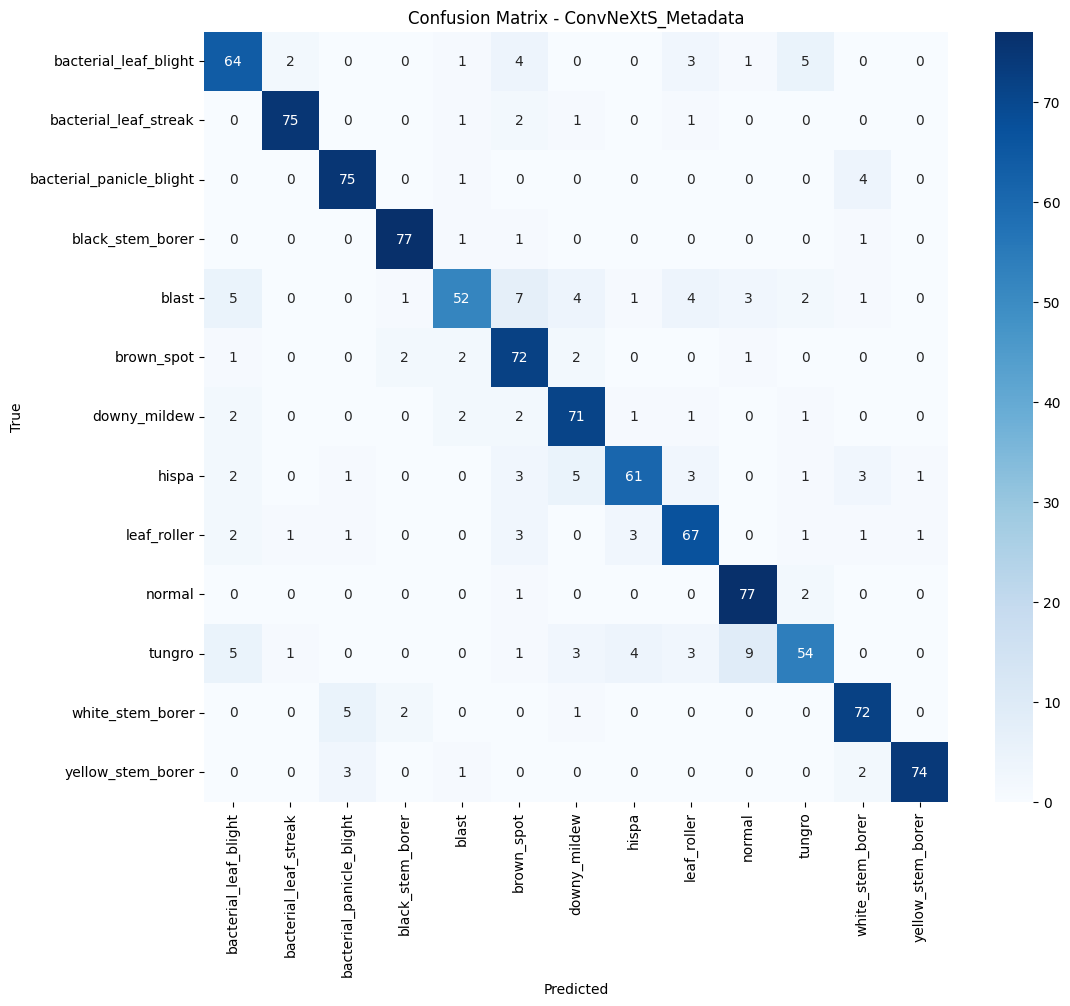

In [6]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test accuracy: {test_acc*100:.2f}%")

y_true, y_pred = [], []
for (imgs, vars_, ages), labs in test_ds:
    preds = model.predict([imgs, vars_, ages], verbose=0)
    y_true.extend(np.argmax(labs.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix - {model.name}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()
